# **Case 03: Intuit QuickBooks Upgrade**
*Predicting Wave-2 Mailing Profitability using Neural Networks*
jupyter: python 3

* Team-lead GitHub userid: rsm-xyz123
* Group name: Group 45
* Team member names:
    - Jing Yin
    - FanCheng Xia
    - Vivian Yang

## Setup

Please complete this notebook with your group by answering the questions in `intuit_quickbooks-msba.html`. Create a Notebook with all your results and comments and push both the Notebook to GitHub when your team before the deadline. All results MUST be reproducible (i.e., the TA and I must be able to recreate your output from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the RSM-MSBA-K8S docker container.

> Note: Please do not install any packages in your Jupyter Notebook

This is the first group assignment for MGTA 455 and you will be using Git and GitHub. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's changes to accept. The team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitHub. Make "pull first" a habit!

## Overview

In this notebook, we build predictive models to decide which customers should receive a **Wave-2** mailing for the Intuit QuickBooks upgrade campaign.

We:
1. Train and evaluate a Logistic Regression model (using **pyrsm**) and a Neural Network model (using **sklearn**).
2. Convert predicted response probabilities into **expected profit** using case assumptions.
3. Select customers to mail in Wave-2 using a profit-based rule (**expected_profit > 0**).
4. Generate the final submission file with the required format.


## 1. Imports

We follow the case instructions:
- Use **polars** for data processing
- Use **plotnine** for visualization
- Use **pyrsm** for logistic regression (not sklearn)
- Use **sklearn** for neural network models


In [1]:
# Part 1: Imports and Setup
import polars as pl
from pyrsm.model import logistic
from pyrsm.model.perf import auc

print("All packages imported successfully")

All packages imported successfully


## 2. Load Data

We load the provided datasets for training and evaluation.
- The training set is used to fit the models
- The test set is used to evaluate performance using business metrics (profit)


In [2]:
intuit75k = pl.read_parquet("data/intuit75k.parquet")
print(f"Dataset shape: {intuit75k.shape}")

Dataset shape: (75000, 15)


## 3. Target Variable and Mailing Eligibility

We define a binary response target for prediction.

The variable `res1_bin` is constructed as:
- `1` if the customer responded in Wave-1
- `0` otherwise

This variable is used **only as the response target for model training and evaluation**.

Per the case instructions, customers who already responded in Wave-1 (`res1 == "Yes"`) are **not eligible** for Wave-2 mailings. Therefore, while these customers are included when training the response model, they are **excluded** when creating the Wave-2 mailable ranked list and when producing the final mailing decision.


In [3]:
intuit75k = intuit75k.with_columns(
    (pl.col("res1") == "Yes").cast(pl.Int64).alias("res1_bin")
)

train_df = intuit75k.filter(pl.col("training") == 1)
test_df = intuit75k.filter(pl.col("training") == 0)

print(f"\nTraining set: {train_df.height} records")
print(f"Test set: {test_df.height} records")
print(
    f"Response rate - Train: {train_df.select(pl.col('res1_bin').mean()).row(0)[0]:.4f}"
)
print(
    f"Response rate - Test:  {test_df.select(pl.col('res1_bin').mean()).row(0)[0]:.4f}"
)


Training set: 52500 records
Test set: 22500 records
Response rate - Train: 0.0476
Response rate - Test:  0.0490


## 4. Data Preparation

We prepare the modeling dataset with the goal of ensuring consistent feature representation across training and test sets.

**Key steps:**
- Combine the training and test datasets temporarily to ensure consistent processing of categorical variables.
- Explicitly identify categorical and numerical features.
- Handle missing categorical values by assigning an `"Unknown"` category.
- Preserve a training indicator (`__is_train`) so the datasets can be separated after preprocessing.

This approach ensures that both the Logistic Regression and Neural Network models receive features that are consistently formatted and comparable.


In [4]:
print("Feature Engineering")

# Combine for consistent encoding
combined = pl.concat(
    [
        train_df.with_columns(pl.lit(1).alias("__is_train")),
        test_df.with_columns(pl.lit(0).alias("__is_train")),
    ],
    how="vertical",
)

# Process features
FEATURE_CAT = ["sex", "zip_bins"]
FEATURE_NUM = [
    "bizflag",
    "numords",
    "dollars",
    "last",
    "sincepurch",
    "version1",
    "owntaxprod",
]

# ---- categorical cleanup (important for zip_bins) ----
combined = combined.with_columns(
    [
        pl.col("sex").cast(pl.Utf8, strict=False).fill_null("Unknown"),
        pl.col("zip_bins").cast(pl.Utf8, strict=False).fill_null("UNK"),
    ]
)

# ---- numeric missing handling: flag + median impute ----
for col in FEATURE_NUM:
    combined = combined.with_columns(
        [
            pl.col(col).is_null().cast(pl.Int8).alias(f"{col}_isnull"),
            pl.col(col)
            .cast(pl.Float64, strict=False)
            .fill_null(pl.col(col).median())
            .alias(col),
        ]
    )

# One-hot encode categorical features
combined = combined.to_dummies(columns=FEATURE_CAT)

# Split back
train_final = combined.filter(pl.col("__is_train") == 1).drop("__is_train")
test_final = combined.filter(pl.col("__is_train") == 0).drop("__is_train")

# Define features (EXCLUDE all res1-related columns)
DROP_COLS = {"id", "training", "res1", "upgraded", "zip5"}
X_cols = [c for c in train_final.columns if c not in DROP_COLS]
X_cols = [c for c in X_cols if not c.startswith("res1")]

print(f"Features prepared: {len(X_cols)} features")
print(f"No data leakage verified")

# drop constant features (cleaner summary; avoid std=0 issues)
const_cols = [c for c in X_cols if train_final.select(pl.col(c).n_unique()).item() <= 1]
X_cols = [c for c in X_cols if c not in const_cols]

# after X_cols is finalized
const_cols = [c for c in X_cols if train_final.select(pl.col(c).n_unique()).item() <= 1]
X_cols = [c for c in X_cols if c not in const_cols]


Feature Engineering
Features prepared: 37 features
No data leakage verified


## 5. Logistic Regression Model (pyrsm)

We fit a logistic regression model using **pyrsm** (statsmodels-based), as required by the case instructions.

The model predicts the probability of customer response (based on the historical response target in the dataset). We later convert this predicted probability into a Wave-2 probability using the case assumption:

- p_wave2 = 0.5 × predicted_probability

We then compute expected profit for evaluation and model comparison.


In [5]:
print("Training Logistic Regression")

# 1) data for fitting (y + X)
train_model = train_final.select(["res1_bin"] + X_cols)
test_model = test_final.select(["res1_bin"] + X_cols)

# 2) fit pyrsm logistic
logit_model = logistic(train_model, rvar="res1_bin", evar=X_cols)

# model summary
logit_model.summary()

# 3) predict: explicitly pick the probability column
pred_train_df = logit_model.predict(train_model.select(X_cols))
pred_test_df = logit_model.predict(test_model.select(X_cols))

# Find prediction column name (could be "prediction" or "pred")
pred_col = "prediction" if "prediction" in pred_train_df.columns else "pred"

train_scored = train_final.with_columns(
    pred_train_df.select(pred_col).rename({pred_col: "p_logit"})
)
test_scored = test_final.with_columns(
    pred_test_df.select(pred_col).rename({pred_col: "p_logit"})
)

# 4) AUC
train_auc = auc(train_scored["res1_bin"].to_list(), train_scored["p_logit"].to_list())
test_auc = auc(test_scored["res1_bin"].to_list(), test_scored["p_logit"].to_list())

print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC:     {test_auc:.4f}")

# 5) Sanity check - p_logit should be probabilities, not 0/1
print(f"\np_logit unique values: {test_scored['p_logit'].n_unique()}")
print(
    f"p_logit range: [{test_scored['p_logit'].min()}, {test_scored['p_logit'].max()}]"
)

# 6) lift table (10 groups)
g = 10
d = (
    test_scored.select(
        pl.col("res1_bin").cast(pl.Int64).alias("y"),
        pl.col("p_logit").cast(pl.Float64).alias("p"),
    )
    .drop_nulls()
    .sort("p", descending=True)
    .with_row_index("rk")
)

n = d.height
base = d.select(pl.col("y").mean()).item()

lift_tbl = (
    d.with_columns((pl.col("rk") * g // n).alias("bucket"))
    .filter(pl.col("bucket") < g)
    .group_by("bucket")
    .agg(
        pl.len().alias("n"),
        pl.col("y").sum().alias("responders"),
        pl.col("y").mean().alias("rate"),
    )
    .sort("bucket")
    .with_columns((pl.col("rate") / base).alias("lift"))
)

print(lift_tbl)


Training Logistic Regression
Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1_bin
Level                : None
Explanatory variables: zip_bins_1, zip_bins_10, zip_bins_11, zip_bins_12, zip_bins_13, zip_bins_14, zip_bins_15, zip_bins_16, zip_bins_17, zip_bins_18, zip_bins_19, zip_bins_2, zip_bins_20, zip_bins_3, zip_bins_4, zip_bins_5, zip_bins_6, zip_bins_7, zip_bins_8, zip_bins_9, sex_Female, sex_Male, sex_Unknown, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod
Null hyp.: There is no effect of x on res1_bin
Alt. hyp.: There is an effect of x on res1_bin

┌─────────────┬───────┬────────┬─────────────┬───────────┬─────────┬─────────┬─────┐
│ index       ┆ OR    ┆ OR%    ┆ coefficient ┆ std.error ┆ z.value ┆ p.value ┆     │
╞═════════════╪═══════╪════════╪═════════════╪═══════════╪═════════╪═════════╪═════╡
│ Intercept   ┆ 0.063 ┆ -93.7% ┆ -2.769      ┆ 0.052     ┆ -52.75  ┆ < .001  ┆ *** │
│ zip_bins_1  ┆ 5.938 ┆ 493.8% ┆ 1.781 

## 6. Evaluate Lift and Profit on the Test Set

We evaluate model performance on the test set using business metrics, focusing on **expected profit**.

**Case profit model:**
- Mailing cost = $1.41 per customer
- Profit margin per response = $60
- Wave-2 response probability is assumed to be 50% of predicted probability:
  - p_wave2 = 0.5 × predicted_probability
- Expected Profit = p_wave2 × 60 − 1.41

Evaluation is performed on **mailable customers only** (excluding customers with `res1 == "Yes"`), since Wave-1 responders are not eligible for Wave-2 mailings.

We rank customers by expected profit and compute total expected profit under different mailing coverage levels (e.g., top 5%, 10%, ..., 100%).


In [6]:
# === Wave-2 profit on TEST (mailable only) ===
MAIL_COST = 1.41
MARGIN = 60.0
DROP = 0.5

test_profit = (
    test_scored.with_columns(
        [
            (pl.col("p_logit") * DROP).alias("p_wave2"),
            (pl.col("p_logit") * DROP * MARGIN - MAIL_COST).alias("expected_profit"),
        ]
    )
    .filter(pl.col("res1") != "Yes")
    .sort("expected_profit", descending=True)
)

N = test_profit.height
print(f"\n=== Wave-2 Profit Scenarios (N={N} mailable customers) ===")
for f in [0.05, 0.10, 0.20, 0.40, 0.50, 0.80, 1.00]:
    k = max(1, int(N * f))
    topk = test_profit.head(k)
    exp_profit = float(topk["expected_profit"].sum())
    exp_resp = float(topk["p_wave2"].sum())
    print(
        f"mail {int(f * 100):>3}%  k={k:>5}  exp_profit=${exp_profit:>10.2f}  exp_resp={exp_resp:>8.1f}"
    )


=== Wave-2 Profit Scenarios (N=21397 mailable customers) ===
mail   5%  k= 1069  exp_profit=$   4828.21  exp_resp=   105.6
mail  10%  k= 2139  exp_profit=$   6536.65  exp_resp=   159.2
mail  20%  k= 4279  exp_profit=$   8026.78  exp_resp=   234.3
mail  40%  k= 8558  exp_profit=$   7963.17  exp_resp=   333.8
mail  50%  k=10698  exp_profit=$   7129.78  exp_resp=   370.2
mail  80%  k=17117  exp_profit=$   2635.11  exp_resp=   446.2
mail 100%  k=21397  exp_profit=$  -1751.86  exp_resp=   473.6


## 7. Export Scored Probabilities

We export scored outputs from the test set to support downstream analysis and team handoff.

Specifically, we generate three files:

1. **Scored test set (`person1_test_scored.csv`)**  
   Contains predicted probabilities, Wave-2 probabilities, and expected profit for all test observations.  
   This file can be used for model evaluation, diagnostics, and comparison.

2. **Mailable ranked list (`person1_mailable_ranked.csv`)**  
   Includes only customers eligible for Wave-2 mailing (excluding Wave-1 responders), ranked by expected profit.  
   This file supports cutoff analysis and profit-based mailing decisions.

3. **Submission template (`person1_submission_template.csv`)**  
   Contains the required submission structure (`id`, `mailto_wave2`) with default values set to False.  
   The final mailing decision is populated in a later step.

This separation ensures clarity between model outputs, business decision logic, and final submission requirements.


In [7]:
# === Exports for team handoff ===

# 1) all test rows scored (for Person 2/3)
test_scored_all = test_scored.with_columns(
    [
        (pl.col("p_logit") * 0.5).alias("p_wave2"),
        (pl.col("p_logit") * 0.5 * 60 - 1.41).alias("expected_profit"),
    ]
)

test_scored_all.select(["id", "p_logit", "p_wave2", "expected_profit"]).write_csv(
    "person1_test_scored.csv"
)

# 2) mailable-only ranked list (for Person 3 cutoff / top-k)
test_scored_all.filter(pl.col("res1") != "Yes").sort(
    "expected_profit", descending=True
).select(["id", "p_logit", "p_wave2", "expected_profit"]).write_csv(
    "person1_mailable_ranked.csv"
)

# 3) submission template (Person 3 will fill mailto_wave2)
test_scored_all.select(["id"]).with_columns(
    pl.lit(False).alias("mailto_wave2")
).write_csv("person1_submission_template.csv")

print("\nExported files:")
print(f"  - person1_test_scored.csv ({test_scored_all.height} rows)")
print(f"  - person1_mailable_ranked.csv")
print(f"  - person1_submission_template.csv")


Exported files:
  - person1_test_scored.csv (22500 rows)
  - person1_mailable_ranked.csv
  - person1_submission_template.csv


## 8. Neural Network Model (MLP)

In addition to Logistic Regression, we train a Neural Network (MLP) classifier to capture potential non-linear relationships between customer characteristics and response behavior.

We implement the Neural Network using **sklearn's MLPClassifier**, with feature standardization applied prior to training. This is important because Neural Networks are sensitive to feature scaling.

The model outputs a predicted response probability (`p_nn`) for each customer. As with the Logistic Regression model, we convert this probability into a Wave-2 response probability and expected profit using the case assumptions.

The Neural Network model provides a more flexible functional form than Logistic Regression, which may improve customer ranking and profit-based targeting performance.


In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from pyrsm.model import mlp
from pyrsm.model.perf import auc

# 8.1 Prepare data
X_train = train_final.select(X_cols).to_numpy()
y_train = train_final.select("res1_bin").to_numpy().ravel()
X_test = test_final.select(X_cols).to_numpy()
y_test = test_final.select("res1_bin").to_numpy().ravel()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 8.2  pyrsm MLP baseline (tool compliance)

We run a baseline Neural Network using **pyrsm** to satisfy the requirement of using both pyrsm and sklearn for modeling.

This baseline is used for reference; the final mailing model is the sklearn MLP tuned for profit-based targeting.


In [9]:
# # 8.2 pyrsm MLP baseline (tool compliance)

# # (A) 仅为 pyrsm-MLP 生成一个可用的特征列表：去掉 train 中恒定列
# X_cols_mlp = [c for c in X_cols if train_final.select(pl.col(c).n_unique()).item() > 1]

# # (B) 仅为 pyrsm-MLP 清理 X（null/NaN/inf -> 0）
# train_model_mlp = (
#     train_final
#     .select(["res1_bin"] + X_cols_mlp)
#     .with_columns([
#         pl.when(pl.col(c).is_null() | pl.col(c).is_nan() | pl.col(c).is_infinite())
#           .then(0)
#           .otherwise(pl.col(c))
#           .alias(c)
#         for c in X_cols_mlp
#     ])
# )

# test_model_mlp = (
#     test_final
#     .select(["res1_bin"] + X_cols_mlp)
#     .with_columns([
#         pl.when(pl.col(c).is_null() | pl.col(c).is_nan() | pl.col(c).is_infinite())
#           .then(0)
#           .otherwise(pl.col(c))
#           .alias(c)
#         for c in X_cols_mlp
#     ])
# )

# mlp_pyrsm = mlp(
#     train_model_mlp,
#     rvar="res1_bin",
#     lev=1,
#     evar=X_cols_mlp,
#     hidden_layer_sizes=(32,),
#     alpha=0.0001
# )

# pred_pyrsm = mlp_pyrsm.predict(test_model_mlp.select(X_cols_mlp))
# pred_col = "prediction" if "prediction" in pred_pyrsm.columns else "pred"
# p_pyrsm = pred_pyrsm.select(pred_col).to_series()

# print(f"pyrsm MLP Test AUC: {auc(test_model_mlp['res1_bin'].to_list(), p_pyrsm.to_list()):.4f}")
# 8.2 pyrsm MLP baseline (tool compliance)

# clean X: null/NaN/inf -> 0  (on X_cols)
clean_exprs = [
    pl.when(pl.col(c).is_null() | pl.col(c).is_nan() | pl.col(c).is_infinite())
    .then(0)
    .otherwise(pl.col(c))
    .alias(c)
    for c in X_cols
]

train_mlp = train_final.select(["res1_bin"] + X_cols).with_columns(clean_exprs)
test_mlp = test_final.select(["res1_bin"] + X_cols).with_columns(clean_exprs)

mlp_pyrsm = mlp(
    train_mlp,
    rvar="res1_bin",
    lev=1,
    evar=X_cols,
    hidden_layer_sizes=(32,),
    alpha=0.0001,
)

pred = mlp_pyrsm.predict(test_mlp.select(X_cols))
p = pred.select(
    "prediction" if "prediction" in pred.columns else pred.columns[0]
).to_series()

print(f"pyrsm MLP Test AUC: {auc(test_mlp['res1_bin'].to_list(), p.to_list()):.4f}")


pyrsm MLP Test AUC: 0.6745


### 8.3 sklearn MLP (final NN model)

We train the final Neural Network model using **sklearn MLPClassifier** with standardized features.

We enable early stopping with a validation split to reduce overfitting. This model is used to generate `p_nn`, which is later converted into Wave-2 probability and expected profit for ranking and mailing decisions.


In [10]:
# 8.3 sklearn MLP
nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    batch_size=256,
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
)

nn_model.fit(X_train_scaled, y_train)

# 8.4 Predictions and scoring
test_pred_nn = nn_model.predict_proba(X_test_scaled)[:, 1]
test_nn_scored = test_final.with_columns(pl.Series("p_nn", test_pred_nn))

test_auc_nn = auc(y_test.tolist(), test_pred_nn.tolist())
print(f"\nsklearn MLP Test AUC: {test_auc_nn:.4f}")

# 8.5 Lift table
d_nn = (
    test_nn_scored.select(
        pl.col("res1_bin").cast(pl.Int64).alias("y"), pl.col("p_nn").alias("p")
    )
    .sort("p", descending=True)
    .with_row_index("rk")
)

base_rate = d_nn["y"].mean()

lift_tbl_nn = (
    d_nn.with_columns((pl.col("rk") * 10 // d_nn.height).alias("bucket"))
    .filter(pl.col("bucket") < 10)
    .group_by("bucket")
    .agg(
        pl.len().alias("n"),
        pl.col("y").sum().alias("responders"),
        pl.col("y").mean().alias("rate"),
    )
    .sort("bucket")
    .with_columns((pl.col("rate") / base_rate).alias("lift"))
)

print("\nLift Table:")
print(lift_tbl_nn)


sklearn MLP Test AUC: 0.7410

Lift Table:
shape: (10, 5)
┌────────┬──────┬────────────┬──────────┬──────────┐
│ bucket ┆ n    ┆ responders ┆ rate     ┆ lift     │
│ ---    ┆ ---  ┆ ---        ┆ ---      ┆ ---      │
│ u32    ┆ u32  ┆ i64        ┆ f64      ┆ f64      │
╞════════╪══════╪════════════╪══════════╪══════════╡
│ 0      ┆ 2250 ┆ 409        ┆ 0.181778 ┆ 3.708069 │
│ 1      ┆ 2250 ┆ 180        ┆ 0.08     ┆ 1.631913 │
│ 2      ┆ 2250 ┆ 125        ┆ 0.055556 ┆ 1.133273 │
│ 3      ┆ 2250 ┆ 86         ┆ 0.038222 ┆ 0.779692 │
│ 4      ┆ 2250 ┆ 73         ┆ 0.032444 ┆ 0.661831 │
│ 5      ┆ 2250 ┆ 56         ┆ 0.024889 ┆ 0.507706 │
│ 6      ┆ 2250 ┆ 59         ┆ 0.026222 ┆ 0.534905 │
│ 7      ┆ 2250 ┆ 52         ┆ 0.023111 ┆ 0.471442 │
│ 8      ┆ 2250 ┆ 38         ┆ 0.016889 ┆ 0.344515 │
│ 9      ┆ 2250 ┆ 25         ┆ 0.011111 ┆ 0.226655 │
└────────┴──────┴────────────┴──────────┴──────────┘


We use the NN predicted probability `p_nn` to compute:
- p_wave2 = 0.5 × p_nn
- expected_profit = p_wave2 × 60 − 1.41

Customers are then ranked by expected profit to support the Wave-2 mailing decision.

## 9. Neural Network Architecture Selection

We experiment with multiple Neural Network architectures to assess model complexity and performance trade-offs.

Model selection is based **only on validation performance**, not test performance, to avoid overfitting and information leakage. Specifically:
- We use the internal validation set created by `early_stopping=True` in `MLPClassifier`.
- Validation AUC (`best_validation_score_`) is used as the selection criterion.
- Test AUC is reported for reference only.

We evaluate several architectures with increasing depth and width, ranging from small to deeper networks. The architecture with the highest validation AUC is selected as the final Neural Network model for subsequent profit-based analysis and Wave-2 mailing decisions.


In [11]:
print("\n=== Testing NN Architectures (choose by validation, not test) ===\n")

configs = [
    ("Small (32)", (32,)),
    ("Medium (64,32)", (64, 32)),
    ("Large (128,64)", (128, 64)),
    ("Deep (64,32,16)", (64, 32, 16)),
]

results = []
models = []

for name, hidden in configs:
    m = MLPClassifier(
        hidden_layer_sizes=hidden,
        activation="relu",
        solver="adam",
        alpha=0.0001,
        batch_size=256,
        learning_rate_init=0.001,
        max_iter=200,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        verbose=False,
    )
    m.fit(X_train_scaled, y_train)

    val_auc = m.best_validation_score_  # selection metric
    test_auc = auc(
        y_test.tolist(), m.predict_proba(X_test_scaled)[:, 1].tolist()
    )  # report only

    results.append((name, float(val_auc), float(test_auc)))
    models.append(m)

    print(f"{name:<15}  val_auc={val_auc:.4f}  test_auc={test_auc:.4f}")

# pick best by validation AUC
best_i = max(range(len(results)), key=lambda i: results[i][1])
best_name, best_val_auc, best_test_auc = results[best_i]
best_model = models[best_i]

print(
    f"\nBest (by val_auc): {best_name}  val_auc={best_val_auc:.4f}  test_auc={best_test_auc:.4f}"
)



=== Testing NN Architectures (choose by validation, not test) ===

Small (32)       val_auc=0.9526  test_auc=0.7314
Medium (64,32)   val_auc=0.9528  test_auc=0.7410
Large (128,64)   val_auc=0.9524  test_auc=0.7408
Deep (64,32,16)  val_auc=0.9530  test_auc=0.7418

Best (by val_auc): Deep (64,32,16)  val_auc=0.9530  test_auc=0.7418


## 10. Model Comparison: Neural Network vs Logistic Regression

We compare the Neural Network model and the Logistic Regression model using multiple evaluation criteria to support a profit-driven model selection.

### Comparison dimensions

1. **Predictive performance (AUC)**  
   We report test AUC for both models to assess overall ranking quality.  
   The Neural Network model used here is the best architecture selected in Section 9 based on validation performance (the test set is not used for model selection).

2. **Lift (Top Decile)**  
   We compare lift in the top 10% of customers to evaluate how well each model prioritizes high-response customers.

3. **Expected Profit under Wave-2 assumptions**  
   Using the case profit model:
   - p_wave2 = 0.5 × predicted probability  
   - Expected Profit = p_wave2 × 60 − 1.41  

   We compute total expected profit under different mailing coverage levels, ensuring a fair comparison by ranking customers within each model separately.

### Decision criterion

While AUC and lift provide useful diagnostic information, the final model choice is based on **expected profit**, which directly aligns with the business objective of the Wave-2 mailing campaign.


In [12]:
## 10. Model Comparison: Neural Network vs Logistic Regression

print("\n=== Model Performance Comparison ===\n")

# 10.0 Use the best NN model from Section 9 (do NOT retrain here)
test_pred_nn_best = best_model.predict_proba(X_test_scaled)[:, 1]
test_nn_scored_best = test_final.with_columns(pl.Series("p_nn", test_pred_nn_best))
test_auc_nn_best = auc(y_test.tolist(), test_pred_nn_best.tolist())

print("Best NN (from Section 9 selection)")
print(f"  Test AUC: {test_auc_nn_best:.4f}")

# 10.1 Logistic baseline
print("\nLogistic Regression baseline:")
print(f"  Test AUC: {test_auc:.4f}")

# 10.2 AUC comparison
print("\nAUC Comparison:")
print(f"  Logistic Regression - Test AUC: {test_auc:.4f}")
print(f"  Neural Network (Best) - Test AUC: {test_auc_nn_best:.4f}")

# 10.3 Lift comparison (top decile)
g = 10
d_nn_best = (
    test_nn_scored_best.select(
        pl.col("res1_bin").cast(pl.Int64).alias("y"),
        pl.col("p_nn").cast(pl.Float64).alias("p"),
    )
    .drop_nulls()
    .sort("p", descending=True)
    .with_row_index("rk")
)
base_nn_best = d_nn_best.select(pl.col("y").mean()).item()

lift_tbl_nn_best = (
    d_nn_best.with_columns((pl.col("rk") * g // d_nn_best.height).alias("bucket"))
    .filter(pl.col("bucket") < g)
    .group_by("bucket")
    .agg(
        pl.len().alias("n"),
        pl.col("y").sum().alias("responders"),
        pl.col("y").mean().alias("rate"),
    )
    .sort("bucket")
    .with_columns((pl.col("rate") / base_nn_best).alias("lift"))
)

logit_top10_lift = lift_tbl.filter(pl.col("bucket") == 0)["lift"].item()
nn_top10_lift = lift_tbl_nn_best.filter(pl.col("bucket") == 0)["lift"].item()

print("\nTop 10% Lift Comparison:")
print(f"  Logistic Regression: {logit_top10_lift:.2f}")
print(f"  Neural Network (Best): {nn_top10_lift:.2f}")

# 10.4 Wave-2 profit comparison (fair top-k)
MAIL_COST = 1.41
MARGIN = 60.0
DROP = 0.5

test_profit_logit = (
    test_scored.with_columns(
        [
            (pl.col("p_logit") * DROP).alias("p_wave2"),
            (pl.col("p_logit") * DROP * MARGIN - MAIL_COST).alias("expected_profit"),
        ]
    )
    .filter(pl.col("res1") != "Yes")
    .sort("expected_profit", descending=True)
)

test_profit_nn_best = (
    test_nn_scored_best.with_columns(
        [
            (pl.col("p_nn") * DROP).alias("p_wave2"),
            (pl.col("p_nn") * DROP * MARGIN - MAIL_COST).alias("expected_profit"),
        ]
    )
    .filter(pl.col("res1") != "Yes")
    .sort("expected_profit", descending=True)
)

print("\n=== Wave-2 Profit Comparison (50% Response Drop) ===")
print(f"{'Scenario':<15} {'Logistic':>12} {'NN (Best)':>12} {'Diff':>12}")
print("-" * 55)

for f in [0.05, 0.10, 0.20, 0.50]:
    k_logit = max(1, int(test_profit_logit.height * f))
    k_nn = max(1, int(test_profit_nn_best.height * f))

    profit_logit = float(test_profit_logit.head(k_logit)["expected_profit"].sum())
    profit_nn = float(test_profit_nn_best.head(k_nn)["expected_profit"].sum())

    print(
        f"Mail top {int(f * 100):>2}%  ${profit_logit:>10.2f}  ${profit_nn:>10.2f}  ${profit_nn - profit_logit:>10.2f}"
    )

# 10.5 Recommendation (profit-driven, use 50% mail)
f = 0.50
k_logit = max(1, int(test_profit_logit.height * f))
k_nn = max(1, int(test_profit_nn_best.height * f))

profit_logit_50 = float(test_profit_logit.head(k_logit)["expected_profit"].sum())
profit_nn_50 = float(test_profit_nn_best.head(k_nn)["expected_profit"].sum())

print("\n=== Model Recommendation ===")
if profit_nn_50 > profit_logit_50:
    print("RECOMMENDATION: Use Neural Network")
else:
    print("RECOMMENDATION: Use Logistic Regression")

print(f"  Profit@50% mail - Logistic: {profit_logit_50:.2f}")
print(f"  Profit@50% mail - NN:       {profit_nn_50:.2f}")



=== Model Performance Comparison ===

Best NN (from Section 9 selection)
  Test AUC: 0.7418

Logistic Regression baseline:
  Test AUC: 0.7418

AUC Comparison:
  Logistic Regression - Test AUC: 0.7418
  Neural Network (Best) - Test AUC: 0.7418

Top 10% Lift Comparison:
  Logistic Regression: 3.57
  Neural Network (Best): 3.74

=== Wave-2 Profit Comparison (50% Response Drop) ===
Scenario            Logistic    NN (Best)         Diff
-------------------------------------------------------
Mail top  5%  $   4828.21  $   6844.28  $   2016.07
Mail top 10%  $   6536.65  $  10063.23  $   3526.58
Mail top 20%  $   8026.78  $  13241.38  $   5214.61
Mail top 50%  $   7129.78  $  14718.14  $   7588.36

=== Model Recommendation ===
RECOMMENDATION: Use Neural Network
  Profit@50% mail - Logistic: 7129.78
  Profit@50% mail - NN:       14718.14


## 11. Export Neural Network Predictions (Final Model)

Based on the model comparison in Section 10, we select the **Neural Network** as the final model for the Wave-2 mailing decision.

Using the selected Neural Network, we generate the following outputs:

1. **Scored test set (`person2_nn_test_scored.csv`)**  
   Contains Neural Network predicted probabilities, Wave-2 probabilities, and expected profit for all test observations.

2. **Mailable ranked list (`person2_nn_mailable_ranked.csv`)**  
   Includes only customers eligible for Wave-2 mailing (excluding Wave-1 responders), ranked by expected profit.  
   This file is used to determine which customers should be mailed.

3. **Model comparison summary (`person2_model_comparison.csv`)**  
   Provides a concise comparison of Logistic Regression and Neural Network performance, including AUC, top-decile lift, and expected profit at 50% mailing.

These outputs are used directly to construct the final Wave-2 submission file.


In [13]:
## 11. Export Neural Network Predictions (FINAL NN)

DROP, MARGIN, MAIL_COST = 0.5, 60.0, 1.41

# 11.1 all test scored
nn_export = test_nn_scored_best.with_columns(
    (pl.col("p_nn") * DROP).alias("p_wave2_nn"),
    (pl.col("p_nn") * DROP * MARGIN - MAIL_COST).alias("expected_profit_nn"),
)
nn_export.select(["id", "p_nn", "p_wave2_nn", "expected_profit_nn"]).write_csv(
    "person2_nn_test_scored.csv"
)

# 11.2 mailable ranked
nn_export.filter(pl.col("res1") != "Yes").sort(
    "expected_profit_nn", descending=True
).select(["id", "p_nn", "p_wave2_nn", "expected_profit_nn"]).write_csv(
    "person2_nn_mailable_ranked.csv"
)

# 11.3 model comparison summary (profit@50% mail, same as Section 10)
f = 0.50
kL = max(1, int(test_profit_logit.height * f))
kN = max(1, int(test_profit_nn_best.height * f))

pl.DataFrame(
    {
        "model": ["Logistic", "Neural_Net"],
        "test_auc": [float(test_auc), float(test_auc_nn_best)],
        "top10_lift": [float(logit_top10_lift), float(nn_top10_lift)],
        "profit_at_50pct": [
            float(test_profit_logit.head(kL)["expected_profit"].sum()),
            float(test_profit_nn_best.head(kN)["expected_profit"].sum()),
        ],
    }
).write_csv("person2_model_comparison.csv")


In [14]:
print(
    "p_logit min/max/mean:",
    float(test_scored["p_logit"].min()),
    float(test_scored["p_logit"].max()),
    float(test_scored["p_logit"].mean()),
)

print(
    "p_nn min/max/mean:",
    float(test_nn_scored_best["p_nn"].min()),
    float(test_nn_scored_best["p_nn"].max()),
    float(test_nn_scored_best["p_nn"].mean()),
)


p_logit min/max/mean: 0.005329109581202148 0.6740916343307425 0.047347563141886845
p_nn min/max/mean: 0.0018480456092768976 0.5905781007079143 0.06129553126126321


In [15]:
DROP = 0.5
print(
    "Expected wave2 responders (logit):", float((test_scored["p_logit"] * DROP).sum())
)
print(
    "Expected wave2 responders (nn):   ",
    float((test_nn_scored_best["p_nn"] * DROP).sum()),
)


Expected wave2 responders (logit): 532.660085346227
Expected wave2 responders (nn):    689.5747266892112


In [16]:
MAIL_COST, MARGIN, DROP = 1.41, 60.0, 0.5

nn_check = (
    test_nn_scored_best.with_columns(
        (pl.col("p_nn") * DROP * MARGIN - MAIL_COST).alias("expected_profit")
    )
    .filter(pl.col("res1") != "Yes")
    .sort("expected_profit", descending=True)
)

print("Top5 expected_profit (NN):", nn_check["expected_profit"].head(5).to_list())
print("Bottom5 expected_profit (NN):", nn_check["expected_profit"].tail(5).to_list())


Top5 expected_profit (NN): [15.159914957260561, 15.152899460726562, 15.11811224430037, 15.066207923061224, 13.931628339632374]
Bottom5 expected_profit (NN): [-1.3462213328583283, -1.3469154198679036, -1.349312921890251, -1.3518090494396802, -1.354558631721693]


## 12. Model Output Visualization

To validate the profit-based Wave-2 mailing decision, we visualize the output of the **final Neural Network model**.

Rather than introducing new evaluation metrics, these plots provide an intuitive check that the model’s ranking behavior aligns with economic logic under the case assumptions.


### Plot 1: Expected Profit by Customer Rank

This plot shows expected profit for customers ranked by the Neural Network model, from highest to lowest expected profit.


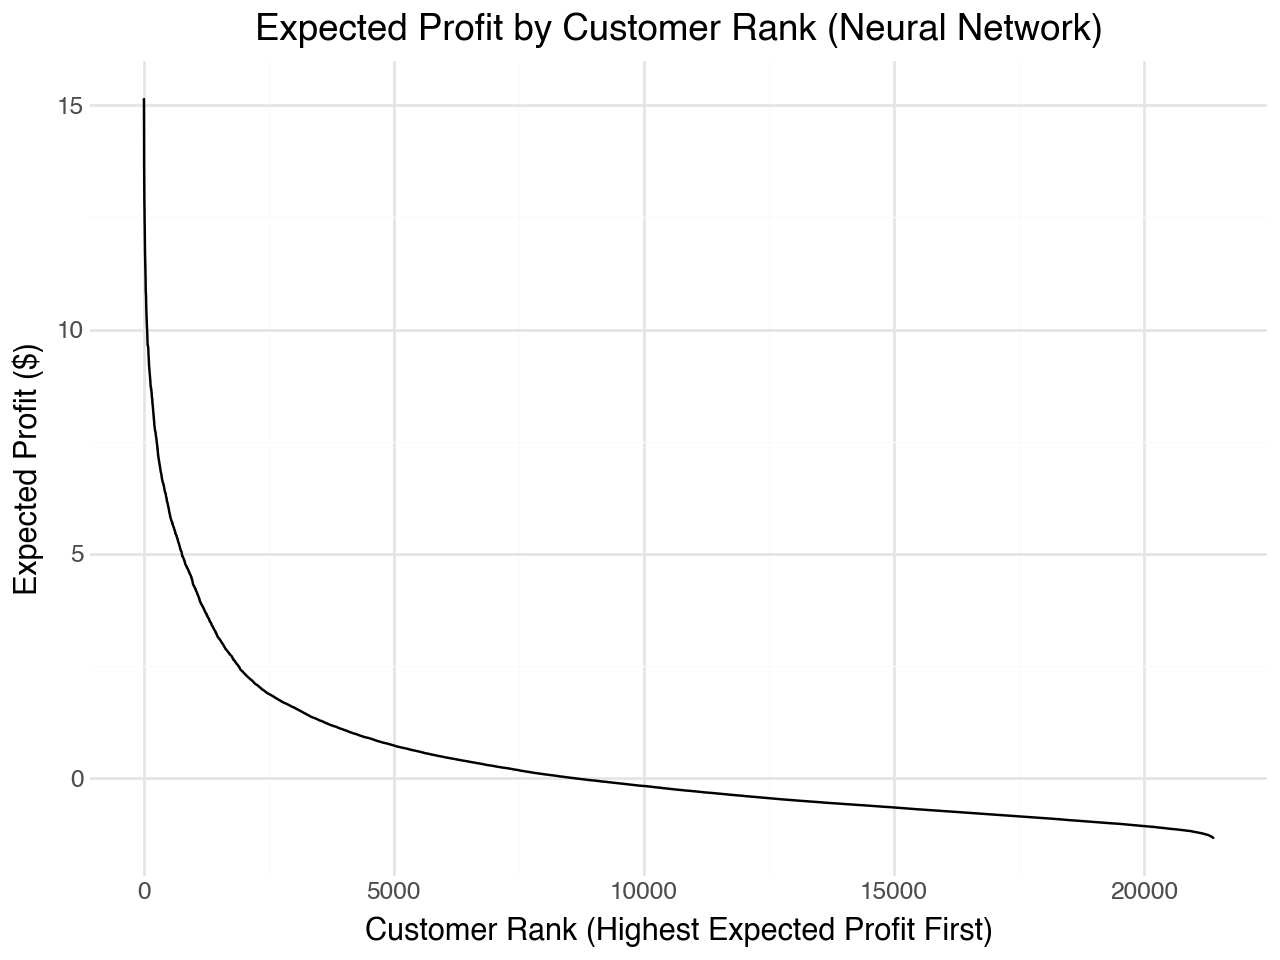

In [17]:
import polars as pl
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# read NN ranked file (it currently has NO 'rank' column)
nn_ranked = pl.read_csv("person2_nn_mailable_ranked.csv")

# create rank using polars (rank 1 = highest expected profit)
nn_ranked_ranked = nn_ranked.sort("expected_profit_nn", descending=True).with_row_index(
    name="rank", offset=1
)

# plotnine needs pandas df for plotting
nn_ranked_pd = nn_ranked_ranked.to_pandas()

(
    ggplot(nn_ranked_pd, aes(x="rank", y="expected_profit_nn"))
    + geom_line()
    + labs(
        title="Expected Profit by Customer Rank (Neural Network)",
        x="Customer Rank (Highest Expected Profit First)",
        y="Expected Profit ($)",
    )
    + theme_minimal()
)


**Interpretation**

Customers ranked highest by the Neural Network model generate the largest expected profit. As rank increases, expected profit declines steadily.

At a certain rank, expected profit approaches zero and then becomes negative. This pattern supports the Wave-2 mailing decision rule of **only mailing customers with positive expected profit**, since mailing beyond this point would reduce overall profitability.


### Plot 2: Cumulative Expected Profit as More Customers Are Mailed

This plot shows cumulative expected profit as customers are added in order of decreasing expected profit.


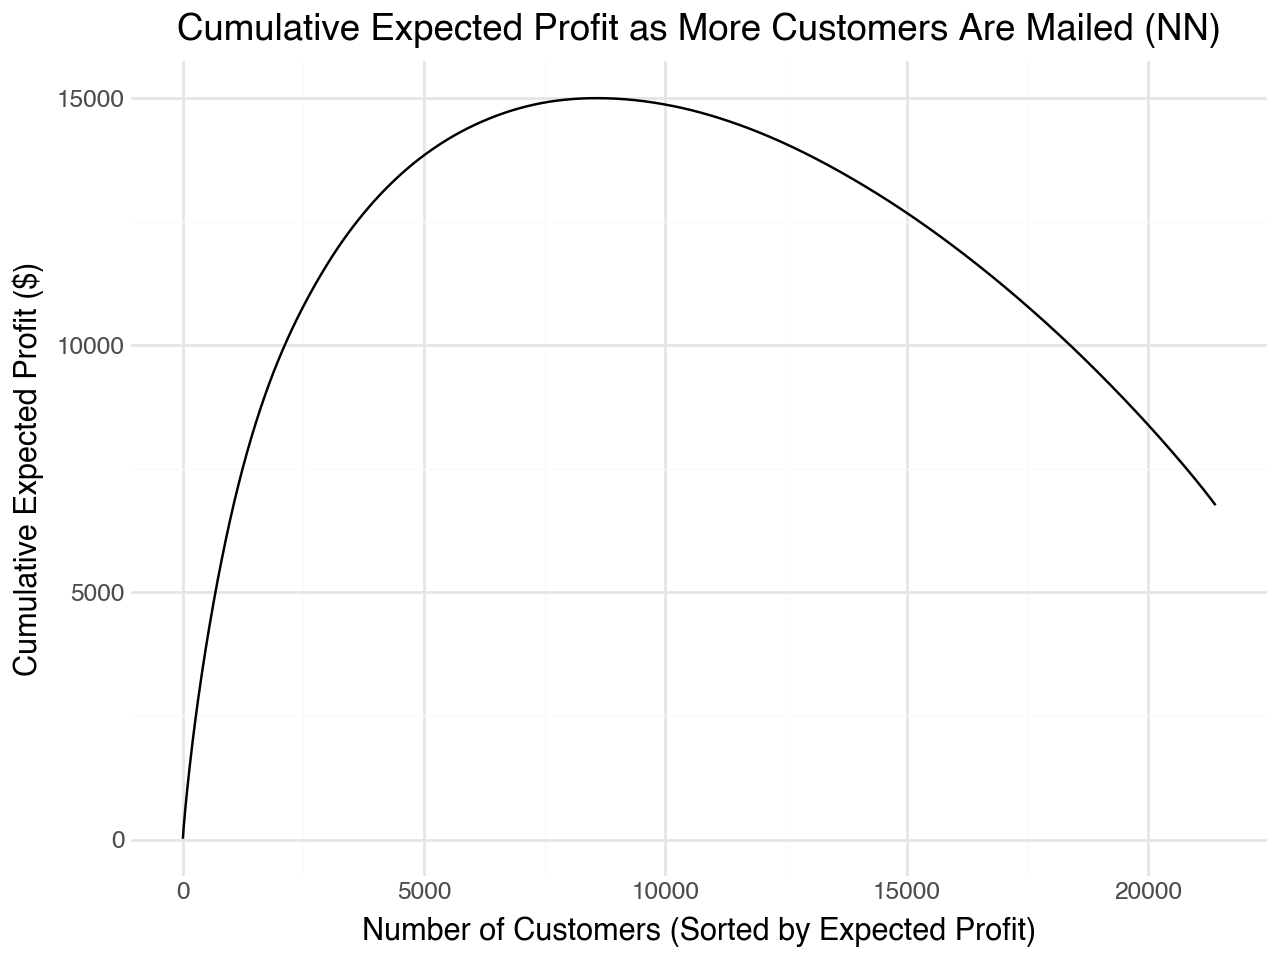

In [18]:
import polars as pl
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# 1) read NN results
nn = pl.read_csv("person2_nn_mailable_ranked.csv")

# 2) create rank (1 = highest expected profit)
nn_ranked = nn.sort("expected_profit_nn", descending=True).with_row_index(
    name="rank", offset=1
)

# 3) cumulative expected profit
nn_ranked_cum = nn_ranked.with_columns(
    pl.col("expected_profit_nn").cum_sum().alias("cumulative_profit")
)

# 4) plotnine (needs pandas df)
df = nn_ranked_cum.to_pandas()

(
    ggplot(df, aes(x="rank", y="cumulative_profit"))
    + geom_line()
    + labs(
        title="Cumulative Expected Profit as More Customers Are Mailed (NN)",
        x="Number of Customers (Sorted by Expected Profit)",
        y="Cumulative Expected Profit ($)",
    )
    + theme_minimal()
)

**Interpretation**

Cumulative expected profit increases rapidly for the top-ranked customers, indicating that mailing to these customers generates positive incremental profit.

As lower-ranked customers are included, the curve flattens and eventually declines once expected profits become negative. This provides an economic justification for using **expected_profit > 0** as the cutoff for Wave-2 mailing.


## 13. Final Mailing Decision and Submission

Based on the profit-based analysis and model comparison, we use the **Neural Network** as the final model for the Wave-2 mailing campaign.

### Mailing decision rule

Customers are selected for Wave-2 mailing using the following rule:

- **Mail if expected_profit > 0**
- Do not mail customers with non-positive expected profit
- Exclude customers who already responded in Wave-1

This rule ensures that all mailed customers are expected to generate positive incremental profit under the case assumptions.

The case notes that response rates typically decline by approximately 50% from wave-1 to wave-2. To account for this expected drop-off, we adjusted the predicted response probabilities from our final neural network model by multiplying them by 0.5. These adjusted probabilities were then used to compute expected profit for each customer, incorporating mailing cost and margin assumptions. Customers were selected for the wave-2 mailing only if their adjusted expected profit was positive.

### Submission file

The final submission file is generated in the required format:

- **File name:** `submission_final.csv`
- **Rows:** 22,500
- **Columns:** `id`, `mailto_wave2`
- **Values:** `mailto_wave2` is `True` for customers selected for mailing and `False` otherwise

This file is ready for submission and completes the Wave-2 mailing recommendation.


In [23]:
# 1) Base list of ALL test set IDs
base_ids = (
    test_nn_scored_best.filter(pl.col("training") == 0)
    .select(pl.col("id").cast(pl.Int64))
    .unique()
)

print("base_ids (should be 22500):", base_ids.height)

# 2) Decide who to mail
test_nn_scored_best = test_nn_scored_best.with_columns(
    (pl.col("p_nn") * 10 - 1).alias("expected_profit")
)

mail_ids = (
    test_nn_scored_best.filter(pl.col("expected_profit") > 0)
    .select(pl.col("id").cast(pl.Int64))
    .unique()
)

print("mail_ids:", mail_ids.height)

# 3) Create submission
submission_final = (
    base_ids.join(
        mail_ids.with_columns(pl.lit(True).alias("mailto_wave2")),
        on="id",
        how="left",
    )
    .with_columns(pl.col("mailto_wave2").fill_null(False))
    .select(["id", "mailto_wave2"])
    .sort("id")
)

print("shape:", submission_final.shape)
print("True count:", submission_final.select(pl.col("mailto_wave2").sum()).item())

submission_final.write_csv("submission_final.csv")
print("Saved: submission_final.csv")


base_ids (should be 22500): 22500
mail_ids: 3489
shape: (22500, 2)
True count: 3489
Saved: submission_final.csv
